In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
%matplotlib inline

## PARAMS

In [3]:
nbins = 2

## LOAD RESP FEATURES & SPINDLES FEATURES

In [4]:
def load_df(patient , stage_to_study=stage_to_study):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    rsp_cycle_file = f'../df_analyse/resp_features_{patient}.xlsx'
    df_cycles = pd.read_excel(rsp_cycle_file).drop(columns = 'Unnamed: 0').loc[:,['cycle_num','inspi_index','expi_index','inspi_time','expi_time','insp_duration','exp_duration','cycle_duration','cycle_freq']]
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage_to_study]
    end_cycles = []
    for cycle in range(df_cycles.shape[0]):
        end_resp = df_cycles.loc[cycle, 'inspi_time'] + df_cycles.loc[cycle, 'cycle_duration']
        end_cycles.append(end_resp)
    df_cycles['end_time'] = end_cycles
    df_cycles
    
    return df_cycles , spindles

In [5]:
df_cycles , spindles = load_df(patient)

In [6]:
df_cycles

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,insp_duration,exp_duration,cycle_duration,cycle_freq,end_time
0,0,106,386,0.414062,1.507812,1.093750,2.386719,3.480469,0.287318,3.894531
1,1,997,1260,3.894531,4.921875,1.027344,1.914062,2.941406,0.339973,6.835938
2,2,1750,2036,6.835938,7.953125,1.117188,1.804688,2.921875,0.342246,9.757812
3,3,2498,2784,9.757812,10.875000,1.117188,1.730469,2.847656,0.351166,12.605469
4,4,3227,3497,12.605469,13.660156,1.054688,1.656250,2.710938,0.368876,15.316406
...,...,...,...,...,...,...,...,...,...,...
2345,2347,1739402,1739660,6794.539062,6795.546875,1.007812,1.707031,2.714844,0.368345,6797.253906
2346,2348,1740097,1740345,6797.253906,6798.222656,0.968750,1.683594,2.652344,0.377025,6799.906250
2347,2349,1740776,1741032,6799.906250,6800.906250,1.000000,1.507812,2.507812,0.398754,6802.414062
2348,2350,1741418,1741675,6802.414062,6803.417969,1.003906,1.441406,2.445312,0.408946,6804.859375


In [7]:
spindles

,patient,stage,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
64,P1,N2,29.062500,29.421875,29.949219,0.886719,50.552506,9.198861,1.681038,0.273174,13.133257,9,0.403509,Fp2-C4,0
65,P1,N2,31.679688,32.152344,32.363281,0.683594,45.307265,11.034409,2.248549,0.552604,12.831427,9,0.687500,Fp2-C4,0
66,P1,N2,35.429688,35.742188,36.015625,0.585938,44.190640,10.303671,2.206344,0.373825,13.945055,8,0.529801,Fp2-C4,0
67,P1,N2,37.644531,37.765625,38.296875,0.652344,48.667588,11.655442,2.139003,0.361292,14.613976,8,0.184524,Fp2-C4,0
68,P1,N2,57.617188,57.996094,58.324219,0.707031,50.900298,10.269619,1.863859,0.237013,13.915378,7,0.532967,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,P1,N2,6028.687500,6029.039062,6029.582031,0.894531,43.629174,9.609003,1.972055,0.368650,14.098065,12,0.391304,T3-O1,7
2260,P1,N2,6077.597656,6077.886719,6078.261719,0.664062,61.166951,12.746160,2.128357,0.310533,13.773895,9,0.432749,T3-O1,7
2261,P1,N2,6092.410156,6092.859375,6093.003906,0.593750,63.201120,13.916322,2.205852,0.323064,14.039903,7,0.751634,T3-O1,7
2262,P1,N2,6123.015625,6123.265625,6123.542969,0.527344,56.735533,11.772413,2.099549,0.266152,14.517329,7,0.470588,T3-O1,7


## COMPUTE WHICH CYCLE CONTAINS SPINDLES

In [8]:
def which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, patient=patient):
    spindles_times = spindles['Peak'].values

    count = []

    for cycle in range(df_cycles.shape[0]):

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()

    return cycles_with_spindle

In [9]:
cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles)

In [10]:
cycles_spindled.size

834

## COMPUTE WHICH RESP PHASE CONTAINS SPINDLES

In [11]:
def count_spindles_phase_resp(nbins, patient, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, show=False):
    spindles_times = spindles['Peak']
    
    count = []

    for cycle in cycle_spindled:
        
        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']

        phases_timings = np.linspace(start, stop, nbins + 1)
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values
        
        for spindle_time in spindles_of_the_cycle:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts().reindex(np.arange(0,nbins))
    phase_count = phase_count.to_frame().T
    phase_count.insert(0 , 'patient', patient)
    
    if show:
        fig, ax = plt.subplots(figsize = (10,6))

        phase_count.plot.bar(ax=ax)
        ax.set_title(f'Count of spindles by resp phase bin')
        ax.set_ylabel('Count of spindles')
        ax.set_xlabel('Phase bin')
        ax.bar_label(ax.containers[0])
        plt.show()
    
    return phase_count

In [12]:
count_spindles_phase_resp(nbins, patient)

,patient,0,1
0,P1,1028,1171


## COMPUTE WHICH OF INSPI or EXPI CONTAINS MORE SPINDLES (NORMALIZED BY DURATION of EACH ONE)

In [13]:
def count_spindles_i_e_norm(spindles = spindles, df_cycles = df_cycles, patient=patient):
    spindles_times = spindles['Peak'].values
    loop = range(df_cycles.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')

    count = []

    for cycle in loop:

        start = df_cycles.loc[cycle,'inspi_time']
        transition = df_cycles.loc[cycle , 'expi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < transition:
                count.append('i')
            elif spindle_time >= transition and spindle_time < stop:
                count.append('e')
            else:
                count.append('Nothing in this cycle')
    count_ser = pd.Series(count).value_counts()
    count_norm = pd.DataFrame.from_dict({'i': round(count_ser.loc['i'] / df_cycles['cycle_freq'].mean() , 2) , 'e' : round(count_ser.loc['e'] / (1 - df_cycles['cycle_freq'].mean()), 2)}, orient = 'index')
    count_norm = count_norm.T
    count_norm.insert(0, 'patient', patient)

    return count_norm

In [14]:
norm_count = count_spindles_i_e_norm()
norm_count

cycle rsp: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2350/2350 [00:00<00:00, 2376.21it/s]


,patient,i,e
0,P1,2166.01,2216.76


In [15]:
df_cycles

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,insp_duration,exp_duration,cycle_duration,cycle_freq,end_time
0,0,106,386,0.414062,1.507812,1.093750,2.386719,3.480469,0.287318,3.894531
1,1,997,1260,3.894531,4.921875,1.027344,1.914062,2.941406,0.339973,6.835938
2,2,1750,2036,6.835938,7.953125,1.117188,1.804688,2.921875,0.342246,9.757812
3,3,2498,2784,9.757812,10.875000,1.117188,1.730469,2.847656,0.351166,12.605469
4,4,3227,3497,12.605469,13.660156,1.054688,1.656250,2.710938,0.368876,15.316406
...,...,...,...,...,...,...,...,...,...,...
2345,2347,1739402,1739660,6794.539062,6795.546875,1.007812,1.707031,2.714844,0.368345,6797.253906
2346,2348,1740097,1740345,6797.253906,6798.222656,0.968750,1.683594,2.652344,0.377025,6799.906250
2347,2349,1740776,1741032,6799.906250,6800.906250,1.000000,1.507812,2.507812,0.398754,6802.414062
2348,2350,1741418,1741675,6802.414062,6803.417969,1.003906,1.441406,2.445312,0.408946,6804.859375


In [26]:
def all_in_one(patient, nbins=nbins):
    df_cycles , spindles = load_df(patient)
    print(patient, spindles.shape[0])
    cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, patient=patient)
    count = count_spindles_phase_resp(nbins=nbins, patient=patient, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, show=False)
    return count

In [27]:
concat = []
for p in  ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']:
    print(p)
    concat.append(all_in_one(p))
df = pd.concat(concat)

P1
P1 2200
P2
P2 2651
P3
P3 3297
P4
P4 2466
P5
P5 2705
P6
P6 1074
P7
P7 5388
P8
P8 903
P9
P9 1015
P10
P10 2672


In [32]:
df_2 = pd.concat(concat).set_index('patient')

In [33]:
df_2

,0,1
patient,,
P1,1028,1171
P2,1144,1499
P3,1426,1855
P4,1188,1278
P5,1069,1295
P6,504,524
P7,2564,2763
P8,403,407
P9,476,506


In [36]:
rows = []
for patient in patients:
    for bin_i in range(nbins):
        rows.append([patient, bin_i, df_2.loc[patient, bin_i]])
df_tidy = pd.DataFrame(rows, columns = ['patient' , 'phase' , 'count'])
   

<AxesSubplot:title={'center':'Effect of phase on count : ** \n N = 10 * 2 \n t-test_paired : p-0.005, cohen-d : 0.247 (S)'}, xlabel='phase', ylabel='count'>

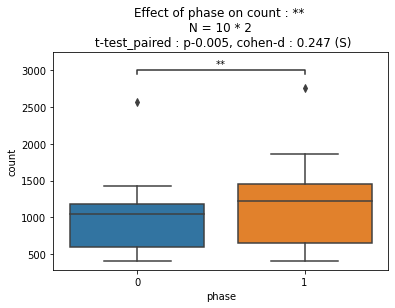

In [41]:
gh.auto_stats(df=df_tidy , predictor = 'phase', outcome = 'count' , design = 'within', ax = ax)

In [47]:
concat = []
for p in  patients:
    print(p)
    concat.append(all_in_one(p, nbins = 20))


P1
P1 2200
P2
P2 2651
P3
P3 3297
P4
P4 2466
P5
P5 2705
P6
P6 1074
P7
P7 5388
P8
P8 903
P9
P9 1015
P10
P10 2672


KeyError: "None of ['P1'] are in the columns"

In [48]:
df_20 = pd.concat(concat)

/tmp/ipykernel_972060/3312757182.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20.mean().plot.bar()


<AxesSubplot:>

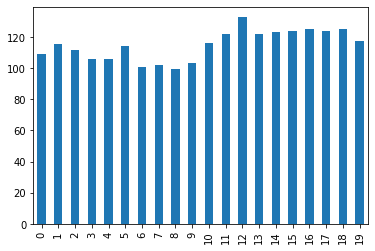

In [51]:
df_20.mean().plot.bar()